# Hodgkin-Huxley Neuron Model

This tutorial demonstrates how to implement biologically realistic neuron models using BrainState. The Hodgkin-Huxley (HH) model is one of the most important models in computational neuroscience, describing action potential generation in neurons through ion channel dynamics.

## Learning Objectives

By the end of this tutorial, you will:
- Understand the Hodgkin-Huxley neuron model
- Use BrainUnit for physical units and dimensional analysis
- Implement biophysically detailed neuron dynamics
- Simulate and visualize neuron spiking activity
- Use BrainState's `Dynamics` class for continuous-time models

## The Hodgkin-Huxley Model

The HH model describes the electrical activity of neurons through:

1. **Membrane Voltage** (`V`): The electrical potential across the cell membrane
2. **Ion Channels**:
   - **Sodium (Na⁺)** channels with activation (`m`) and inactivation (`h`) gates
   - **Potassium (K⁺)** channels with activation (`n`) gates
   - **Leak** channels

**Governing Equations**:
```
C dV/dt = -I_Na - I_K - I_leak + I_ext
I_Na = gNa * m³ * h * (V - ENa)
I_K = gK * n⁴ * (V - EK)
I_leak = gL * (V - EL)
```

Each gate variable (m, h, n) follows:
```
dx/dt = α(V) * (1 - x) - β(V) * x
```

## Setup and Imports

In [1]:
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt

import brainstate

# Set random seed
brainstate.random.seed(42)

## Implementing the HH Model

We'll use BrainState's `nn.Dynamics` class for continuous-time dynamics and BrainUnit for physical units:

In [2]:
class HH(brainstate.nn.Dynamics):
    """Hodgkin-Huxley neuron model.
    
    A biophysically detailed model of action potential generation.
    """
    
    def __init__(
        self,
        in_size,
        ENa=50. * u.mV,              # Sodium reversal potential
        gNa=120. * u.mS / u.cm ** 2, # Sodium conductance
        EK=-77. * u.mV,              # Potassium reversal potential  
        gK=36. * u.mS / u.cm ** 2,   # Potassium conductance
        EL=-54.387 * u.mV,           # Leak reversal potential
        gL=0.03 * u.mS / u.cm ** 2,  # Leak conductance
        V_th=20. * u.mV,             # Spike threshold
        C=1.0 * u.uF / u.cm ** 2     # Membrane capacitance
    ):
        super().__init__(in_size)
        
        # Store parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.C = C
        self.V_th = V_th
    
    # Sodium channel activation (m)
    def m_alpha(self, V):
        return 1. / u.math.exprel(-(V / u.mV + 40) / 10)
    
    def m_beta(self, V):
        return 4.0 * jnp.exp(-(V / u.mV + 65) / 18)
    
    def m_inf(self, V):
        return self.m_alpha(V) / (self.m_alpha(V) + self.m_beta(V))
    
    def dm(self, m, t, V):
        return (self.m_alpha(V) * (1 - m) - self.m_beta(V) * m) / u.ms
    
    # Sodium channel inactivation (h)
    def h_alpha(self, V):
        return 0.07 * jnp.exp(-(V / u.mV + 65) / 20.)
    
    def h_beta(self, V):
        return 1 / (1 + jnp.exp(-(V / u.mV + 35) / 10))
    
    def h_inf(self, V):
        return self.h_alpha(V) / (self.h_alpha(V) + self.h_beta(V))
    
    def dh(self, h, t, V):
        return (self.h_alpha(V) * (1 - h) - self.h_beta(V) * h) / u.ms
    
    # Potassium channel activation (n)
    def n_alpha(self, V):
        return 0.1 / u.math.exprel(-(V / u.mV + 55) / 10)
    
    def n_beta(self, V):
        return 0.125 * jnp.exp(-(V / u.mV + 65) / 80)
    
    def n_inf(self, V):
        return self.n_alpha(V) / (self.n_alpha(V) + self.n_beta(V))
    
    def dn(self, n, t, V):
        return (self.n_alpha(V) * (1 - n) - self.n_beta(V) * n) / u.ms
    
    def init_state(self, batch_size=None):
        """Initialize state variables at rest."""
        self.V = brainstate.HiddenState(
            jnp.ones(self.varshape, brainstate.environ.dftype()) * -65. * u.mV
        )
        self.m = brainstate.HiddenState(self.m_inf(self.V.value))
        self.h = brainstate.HiddenState(self.h_inf(self.V.value))
        self.n = brainstate.HiddenState(self.n_inf(self.V.value))
    
    def dV(self, V, t, m, h, n, I):
        """Membrane voltage dynamics."""
        I = self.sum_current_inputs(I, V)
        
        # Sodium current
        I_Na = (self.gNa * m * m * m * h) * (V - self.ENa)
        
        # Potassium current
        n2 = n * n
        I_K = (self.gK * n2 * n2) * (V - self.EK)
        
        # Leak current
        I_leak = self.gL * (V - self.EL)
        
        # Total current
        dVdt = (- I_Na - I_K - I_leak + I) / self.C
        return dVdt
    
    def update(self, x=0. * u.mA / u.cm ** 2):
        """Update neuron state for one time step.
        
        Args:
            x: Input current density
            
        Returns:
            spike: Boolean spike indicator
        """
        t = brainstate.environ.get('t')
        
        # Update voltage and gating variables using exponential Euler
        V = brainstate.nn.exp_euler_step(
            self.dV, self.V.value, t, 
            self.m.value, self.h.value, self.n.value, x
        )
        m = brainstate.nn.exp_euler_step(self.dm, self.m.value, t, self.V.value)
        h = brainstate.nn.exp_euler_step(self.dh, self.h.value, t, self.V.value)
        n = brainstate.nn.exp_euler_step(self.dn, self.n.value, t, self.V.value)
        
        # Sum delta inputs (for synaptic inputs)
        V = self.sum_delta_inputs(init=V)
        
        # Detect spike (threshold crossing)
        spike = jnp.logical_and(self.V.value < self.V_th, V >= self.V_th)
        
        # Update states
        self.V.value = V
        self.m.value = m
        self.h.value = h
        self.n.value = n
        
        return spike

## Simulating the HH Neuron

### Create and Initialize Neuron

In [4]:
# Create a population of 10 HH neurons
hh = HH(10)

# Initialize states
brainstate.nn.init_all_states(hh)

# Set simulation parameters
dt = 0.01 * u.ms
brainstate.environ.set(dt=dt)

print(f"Created {hh.varshape} HH neurons")
print(f"Initial membrane potential: {hh.V.value[0]}")

Created (10,) HH neurons
Initial membrane potential: -65.0 * mvolt


### Define Simulation Function

In [5]:
def run(t, inp):
    """Run neuron for one time step.
    
    Args:
        t: Current time
        inp: Input current
        
    Returns:
        V: Membrane voltage
    """
    with brainstate.environ.context(t=t, dt=dt):
        hh(inp)
    return hh.V.value

### Run Simulation with Random Input

In [6]:
# Simulation duration
duration = 100. * u.ms
times = u.math.arange(0. * u.ms, duration, dt)

# Generate random input currents
inputs = brainstate.random.uniform(1., 10., times.shape) * u.uA / u.cm ** 2

print(f"Running simulation for {duration}...")

# Run simulation with progress bar
vs = brainstate.transform.for_loop(
    run,
    times, 
    inputs,
    pbar=brainstate.transform.ProgressBar(count=100)
)

print("Simulation complete!")

Running simulation for 100.0 * msecond...


  0%|          | 0/10000 [00:00<?, ?it/s]

Simulation complete!


## Visualizing Results

### Plot Membrane Voltage Traces

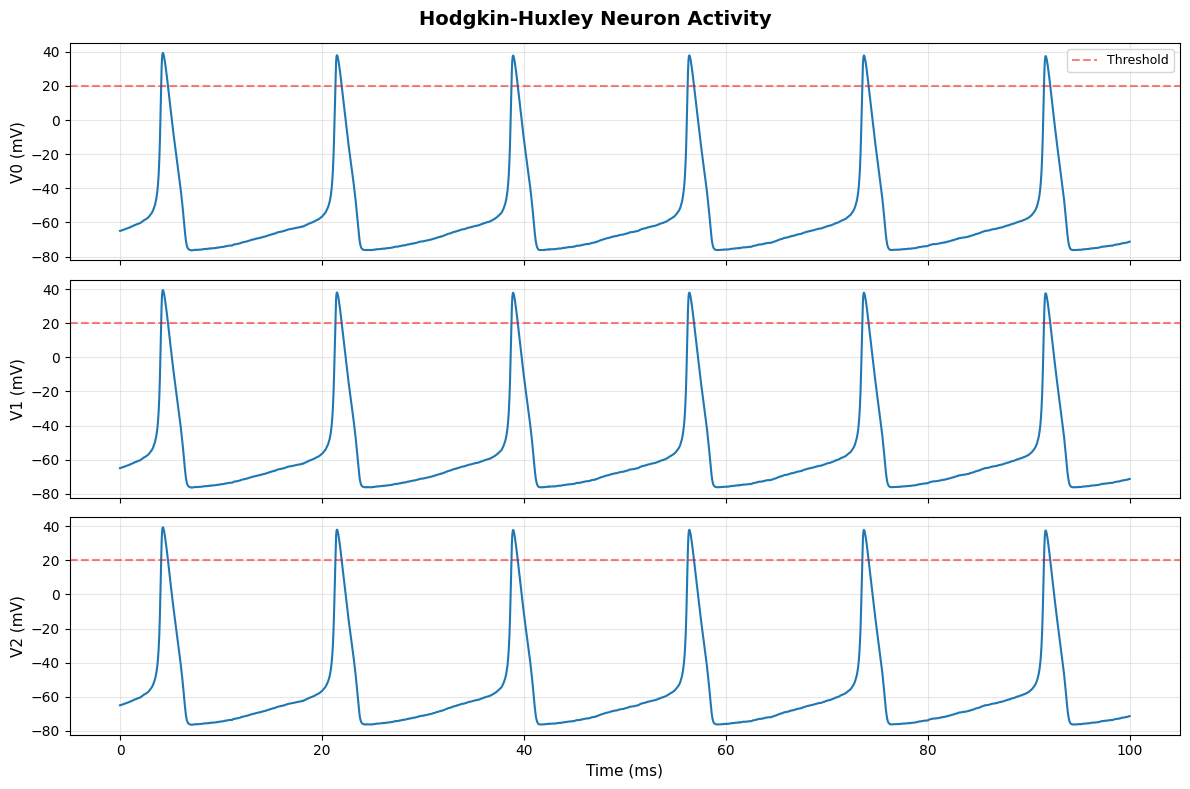

In [7]:
# Convert to milliseconds and millivolts for plotting
times_ms = times.to_decimal(u.ms)
vs_mv = vs.to_decimal(u.mV)

# Plot voltage traces for first 3 neurons
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

for i in range(3):
    axes[i].plot(times_ms, vs_mv[:, i], linewidth=1.5)
    axes[i].set_ylabel(f'V{i} (mV)', fontsize=11)
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=20, color='r', linestyle='--', alpha=0.5, label='Threshold')
    if i == 0:
        axes[i].legend(fontsize=9)

axes[2].set_xlabel('Time (ms)', fontsize=11)
plt.suptitle('Hodgkin-Huxley Neuron Activity', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Analyze Spiking Statistics

In [9]:
# Detect spikes (threshold crossings)
import numpy as np

threshold = 20.0  # mV
spike_times = []
spike_counts = []

for i in range(hh.varshape[0]):
    # Find threshold crossings
    above_threshold = vs_mv[:, i] > threshold
    spike_indices = np.where(np.diff(above_threshold.astype(int)) > 0)[0]
    
    spike_times.append(times_ms[spike_indices])
    spike_counts.append(len(spike_indices))

print("Spike counts per neuron:")
for i, count in enumerate(spike_counts[:5]):
    print(f"  Neuron {i}: {count} spikes")

print(f"\nAverage firing rate: {np.mean(spike_counts) / (duration.to_decimal(u.ms) / 1000):.2f} Hz")

Spike counts per neuron:
  Neuron 0: 6 spikes
  Neuron 1: 6 spikes
  Neuron 2: 6 spikes
  Neuron 3: 6 spikes
  Neuron 4: 6 spikes

Average firing rate: 60.00 Hz


### Raster Plot

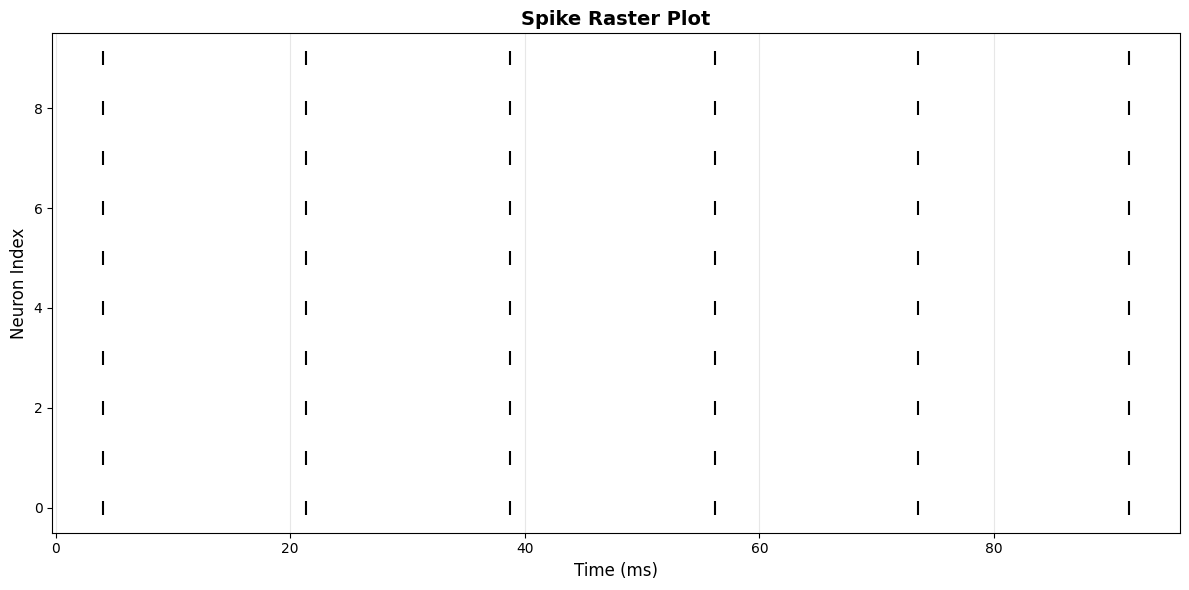

In [10]:
plt.figure(figsize=(12, 6))

for i, spikes in enumerate(spike_times[:10]):
    plt.scatter(spikes, [i] * len(spikes), marker='|', s=100, color='black')

plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Neuron Index', fontsize=12)
plt.title('Spike Raster Plot', fontsize=14, fontweight='bold')
plt.ylim(-0.5, 9.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Key Concepts Summary

**Hodgkin-Huxley Model**

1. **Biophysical Realism**:
   - Detailed ion channel dynamics
   - Accurate spike generation mechanism
   - Based on Nobel Prize-winning research

2. **State Variables**:
   - `V`: Membrane potential
   - `m`, `h`, `n`: Gating variables for ion channels

3. **Physical Units**:
   - BrainUnit ensures dimensional consistency
   - Prevents unit errors in equations
   - Makes code more readable and maintainable

**BrainState Features**

1. **`nn.Dynamics`**: Base class for continuous-time dynamical systems
2. **`exp_euler_step`**: Exponential Euler integration for stiff ODEs
3. **`HiddenState`**: For dynamical state variables
4. **`for_loop`**: Efficient simulation over time steps

**Applications**

- Understanding neuronal excitability
- Studying effects of channel blockers
- Modeling pathological conditions (epilepsy, etc.)
- Brain-machine interfaces
- Neuromorphic computing

## Exercises

1. **Explore Parameter Space**:
   - Vary conductances (gNa, gK, gL)
   - Observe effects on spiking patterns

2. **Different Input Patterns**:
   - Constant current injection
   - Step current protocol
   - Sinusoidal input

3. **Network Simulation**:
   - Connect multiple HH neurons
   - Implement synaptic transmission
   - Observe network dynamics

4. **Simplified Models**:
   - Implement Izhikevich model
   - Compare computational efficiency
   - Analyze spike train statistics

## Next Steps

- **Network Models**: Build networks of neurons with synapses
- **Learning Rules**: Implement STDP and other plasticity mechanisms
- **Brain Regions**: Model cortical columns, hippocampus, etc.
- **Spiking Networks**: Training spiking neural networks

## References

- [Hodgkin & Huxley (1952) Original Paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392413/)
- [Neuronal Dynamics Book](https://neuronaldynamics.epfl.ch/)
- [BrainState Documentation](https://brainstate.readthedocs.io/)
- [BrainUnit Documentation](https://brainunit.readthedocs.io/)